# Text Prediction - Customization and HPO

In this tutorial, we will learn how to customize the `TextPrediction` task in AutoGluon. We will use the "Paraphrasing Identification" for illustration. The goal of the task is to identify whether one sentence is a restatement of the other. In this example, we will use the [Microsoft Research Paraphrase Corpus](https://www.microsoft.com/en-us/download/details.aspx?id=52398). 

In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Load Data

In [2]:
from autogluon.utils.tabular.utils.loaders import load_pd

train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/train.parquet')
dev_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/dev.parquet')
train_data.head(10)

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/train.parquet | Columns = 3 / 3 | Rows = 3668 -> 3668
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/mrpc/dev.parquet | Columns = 3 / 3 | Rows = 408 -> 408


,sentence1,sentence2,label
0,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr...",1
1,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...,0
2,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ...",1
3,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set...",0
4,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...,1
5,Revenue in the first quarter of the year dropp...,With the scandal hanging over Stewart 's compa...,1
6,"The Nasdaq had a weekly gain of 17.27 , or 1.2...",The tech-laced Nasdaq Composite .IXIC rallied ...,0
7,The DVD-CCA then appealed to the state Supreme...,The DVD CCA appealed that decision to the U.S....,1
8,"That compared with $ 35.18 million , or 24 cen...",Earnings were affected by a non-recurring $ 8 ...,0
9,"Shares of Genentech , a much larger company wi...",Shares of Xoma fell 16 percent in early trade ...,0


In [3]:
from autogluon_contrib_nlp.data.tokenizers import MosesTokenizer
tokenizer = MosesTokenizer('en')
print('Paraphrase:')
print('Sentence1: ', tokenizer.decode(train_data['sentence1'][5].split()))
print('Sentence2: ', tokenizer.decode(train_data['sentence2'][5].split()))
print('Label: ', train_data['label'][2])

print('\nNot Paraphrase:')
print('Sentence1:', tokenizer.decode(train_data['sentence1'][8].split()))
print('Sentence2:', tokenizer.decode(train_data['sentence2'][8].split()))
print('Label:', train_data['label'][3])

Paraphrase:
Sentence1:  Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier.
Sentence2:  With the scandal hanging over Stewart's company, revenue the first quarter of the year dropped 15 percent from the same period a year earlier.
Label:  1

Not Paraphrase:
Sentence1: That compared with $35.18 million, or 24 cents per share, in the year-ago period.
Sentence2: Earnings were affected by a non-recurring $8 million tax benefit in the year-ago period.
Label: 0


## Explore a Custoimzed Search Space with Random Search

Here, we can set the `hyperparameters` argument and specify the search space with `ag.space`. In this example, we search for the `warmup_portion`, `learning_rate`, `data_dropout`, `layerwise_lr_decay`, and `num_layers`.

2020-08-02 09:29:33,370 - root - INFO - All Logs will be saved to ./ag_mrpc_random_search/ag_text_prediction.log
2020-08-02 09:29:33,386 - root - INFO - Train Dataset:
2020-08-02 09:29:33,387 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=3117/0
   length, min/avg/max=38/118.59/226
)
- Text(
   name="sentence2"
   #total/missing=3117/0
   length, min/avg/max=42/118.93/215
)
- Categorical(
   name="label"
   #total/missing=3117/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[1017, 2100]
)


2020-08-02 09:29:33,387 - root - INFO - Tuning Dataset:
2020-08-02 09:29:33,388 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=551/0
   length, min/avg/max=40/117.86/205
)
- Text(
   name="sentence2"
   #total/missing=551/0
   length, min/avg/max=48/117.86/205
)
- Categorical(
   name="label"
   #total/missing=551/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[177, 374]
)


2020-08-02 09:29:33,388 - root - IN

 43%|████▎     | 165/388 [00:31<00:30,  7.41it/s]

 69%|██████▉   | 269/388 [00:48<00:21,  5.54it/s]


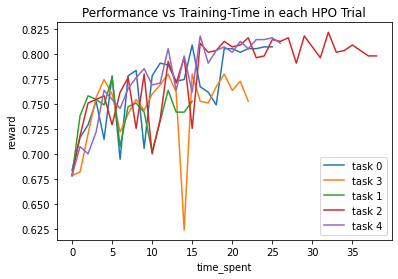

In [4]:
import autogluon as ag
from autogluon import TextPrediction as task

hyperparameters = {
    'models': {
            'BertForTextPredictionBasic': {
                'search_space': {
                    'model.network.agg_net.num_layers': ag.space.Categorical(0, 1, 2),
                    'model.network.agg_net.data_dropout': ag.space.Categorical(False, True),
                    'optimization.num_train_epochs': 4,
                    'optimization.warmup_portion': ag.space.Real(0.1, 0.2),
                    'optimization.layerwise_lr_decay': ag.space.Real(0.8, 1.0),
                    'optimization.lr': ag.space.Real(1E-5, 1E-4)
                }
            }
    },
    'hpo_params': {
        'scheduler': 'fifo',
        'search_strategy': 'random'
    }
}

predictor_mrpc = task.fit(train_data, label='label',
                          hyperparameters=hyperparameters,
                          num_trials=5,
                          time_limits=60 * 5, ngpus_per_trial=1, seed=123,
                          output_directory='./ag_mrpc_random_search')

In [5]:
dev_score = predictor_mrpc.evaluate(dev_data, metrics=['acc', 'f1'])
print('Best Config = {}'.format(predictor_mrpc.results['best_config']))
print('Total Time = {}s'.format(predictor_mrpc.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))
print('F1 = {:.2f}%'.format(dev_score['f1'] * 100))

Best Config = {'search_space▁model.network.agg_net.data_dropout▁choice': 1, 'search_space▁model.network.agg_net.num_layers▁choice': 1, 'search_space▁optimization.layerwise_lr_decay': 0.8333501491631055, 'search_space▁optimization.lr': 6.860067163930919e-05, 'search_space▁optimization.warmup_portion': 0.17063176107868006}
Total Time = 92.5273380279541s
Accuracy = 82.84%
F1 = 88.14%


In [6]:
predictions = predictor_mrpc.predict(dev_data)
sentence1 = 'It is simple to solve NLP problems with AutoGluon.'
sentence2 = 'With AutoGluon, it is easy to solve NLP problems.'
sentence3 = 'AutoGluon gives you a very bad user experience for solving NLP problems.'
prediction1 = predictor_mrpc.predict({'sentence1': [sentence1], 'sentence2': [sentence2]})
prediction1_prob = predictor_mrpc.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence2]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence2))
print('Prediction = "{}"'.format(prediction1[0] == 1))
print('Prob = "{}"'.format(prediction1_prob[0]))
print('')
prediction2 = predictor_mrpc.predict({'sentence1': [sentence1], 'sentence2': [sentence3]})
prediction2_prob = predictor_mrpc.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence3]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence3))
print('Prediction = "{}"'.format(prediction2[0] == 1))
print('Prob = "{}"'.format(prediction2_prob[0]))

A = "It is simple to solve NLP problems with AutoGluon."
B = "With AutoGluon, it is easy to solve NLP problems."
Prediction = "True"
Prob = "[0.05875021 0.9412498 ]"

A = "It is simple to solve NLP problems with AutoGluon."
B = "AutoGluon gives you a very bad user experience for solving NLP problems."
Prediction = "False"
Prob = "[0.7339565  0.26604348]"


## Use Bayesian Optimization

Apart from random search, we can use the scikit-optimize package as the searcher:

2020-08-02 09:31:12,126 - root - INFO - All Logs will be saved to ./ag_mrpc_custom_space_fifo_skopt/ag_text_prediction.log
2020-08-02 09:31:12,142 - root - INFO - Train Dataset:
2020-08-02 09:31:12,142 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=3117/0
   length, min/avg/max=38/118.45/226
)
- Text(
   name="sentence2"
   #total/missing=3117/0
   length, min/avg/max=42/118.88/212
)
- Categorical(
   name="label"
   #total/missing=3117/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[1009, 2108]
)


2020-08-02 09:31:12,143 - root - INFO - Tuning Dataset:
2020-08-02 09:31:12,143 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=551/0
   length, min/avg/max=45/118.65/205
)
- Text(
   name="sentence2"
   #total/missing=551/0
   length, min/avg/max=53/118.14/215
)
- Categorical(
   name="label"
   #total/missing=551/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[185, 366]
)


2020-08-02 09:31:12,143 -

 81%|████████  | 314/388 [00:58<00:11,  6.34it/s]

100%|██████████| 388/388 [01:07<00:00,  5.72it/s]


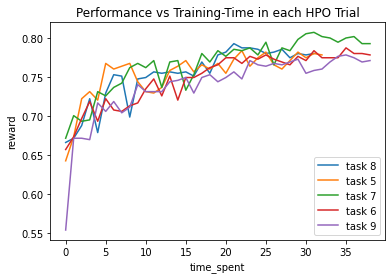

In [7]:
hyperparameters['hpo_params'] = {
    'scheduler': 'fifo',
    'search_strategy': 'skopt'
}

predictor_mrpc_skopt = task.fit(train_data, label='label',
                                hyperparameters=hyperparameters,
                                time_limits=60 * 5,
                                num_trials=5,
                                ngpus_per_trial=1, seed=123,
                                output_directory='./ag_mrpc_custom_space_fifo_skopt')

In [8]:
dev_score = predictor_mrpc_skopt.evaluate(dev_data, metrics=['acc', 'f1'])
print('Best Config = {}'.format(predictor_mrpc_skopt.results['best_config']))
print('Total Time = {}s'.format(predictor_mrpc_skopt.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))
print('F1 = {:.2f}%'.format(dev_score['f1'] * 100))

Best Config = {'search_space▁model.network.agg_net.data_dropout▁choice': 0, 'search_space▁model.network.agg_net.num_layers▁choice': 2, 'search_space▁optimization.layerwise_lr_decay': 0.8927640128151711, 'search_space▁optimization.lr': 6.68360725095595e-05, 'search_space▁optimization.warmup_portion': 0.19412409632412153}
Total Time = 138.81910848617554s
Accuracy = 83.82%
F1 = 88.26%


In [9]:
predictions = predictor_mrpc_skopt.predict(dev_data)
prediction1 = predictor_mrpc_skopt.predict({'sentence1': [sentence1], 'sentence2': [sentence2]})
prediction1_prob = predictor_mrpc_skopt.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence2]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence2))
print('Prediction = "{}"'.format(prediction1[0] == 1))
print('Prob = "{}"'.format(prediction1_prob[0]))
print('')
prediction2 = predictor_mrpc_skopt.predict({'sentence1': [sentence1], 'sentence2': [sentence3]})
prediction2_prob = predictor_mrpc_skopt.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence3]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence3))
print('Prediction = "{}"'.format(prediction2[0] == 1))
print('Prob = "{}"'.format(prediction2_prob[0]))

A = "It is simple to solve NLP problems with AutoGluon."
B = "With AutoGluon, it is easy to solve NLP problems."
Prediction = "True"
Prob = "[0.00109729 0.9989027 ]"

A = "It is simple to solve NLP problems with AutoGluon."
B = "AutoGluon gives you a very bad user experience for solving NLP problems."
Prediction = "False"
Prob = "[0.78841054 0.21158938]"


## Use Hyperband

We can also use the [Hyperband algorithm](https://arxiv.org/pdf/1603.06560.pdf):

In [10]:
hyperparameters['hpo_params'] = {
    'scheduler': 'hyperband',
    'search_strategy': 'random',
    'max_t': 40,
}

2020-08-02 09:33:37,068 - root - INFO - All Logs will be saved to ./ag_mrpc_custom_space_hyperband/ag_text_prediction.log
2020-08-02 09:33:37,083 - root - INFO - Train Dataset:
2020-08-02 09:33:37,084 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=3117/0
   length, min/avg/max=38/118.75/220
)
- Text(
   name="sentence2"
   #total/missing=3117/0
   length, min/avg/max=43/119.08/215
)
- Categorical(
   name="label"
   #total/missing=3117/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[1015, 2102]
)


2020-08-02 09:33:37,084 - root - INFO - Tuning Dataset:
2020-08-02 09:33:37,085 - root - INFO - Columns:

- Text(
   name="sentence1"
   #total/missing=551/0
   length, min/avg/max=38/116.98/226
)
- Text(
   name="sentence2"
   #total/missing=551/0
   length, min/avg/max=42/116.99/210
)
- Categorical(
   name="label"
   #total/missing=551/0
   num_class (total/non_special)=2/2
   categories=[0, 1]
   freq=[179, 372]
)


2020-08-02 09:33:37,085 - 

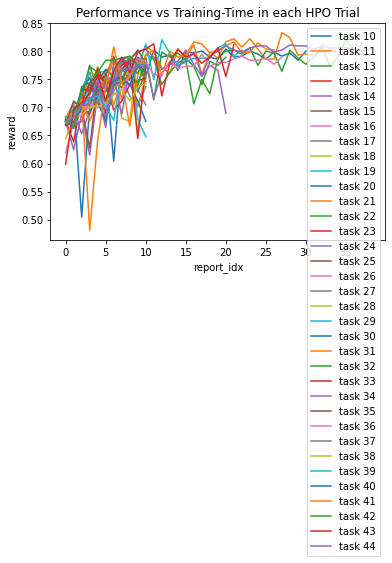

In [11]:
predictor_mrpc_hyperband = task.fit(train_data, label='label',
                                    hyperparameters=hyperparameters,
                                    time_limits=60 * 5, ngpus_per_trial=1, seed=123,
                                    output_directory='./ag_mrpc_custom_space_hyperband')

In [12]:
dev_score = predictor_mrpc_hyperband.evaluate(dev_data, metrics=['acc', 'f1'])
print('Best Config = {}'.format(predictor_mrpc_hyperband.results['best_config']))
print('Total Time = {}s'.format(predictor_mrpc_hyperband.results['total_time']))
print('Accuracy = {:.2f}%'.format(dev_score['acc'] * 100))
print('F1 = {:.2f}%'.format(dev_score['f1'] * 100))

Best Config = {'search_space▁model.network.agg_net.data_dropout▁choice': 0, 'search_space▁model.network.agg_net.num_layers▁choice': 1, 'search_space▁optimization.layerwise_lr_decay': 0.9631701362919186, 'search_space▁optimization.lr': 7.830440237877588e-05, 'search_space▁optimization.warmup_portion': 0.1335546508235886}
Total Time = 345.5544044971466s
Accuracy = 81.62%
F1 = 87.05%


In [13]:
predictions = predictor_mrpc_hyperband.predict(dev_data)
prediction1 = predictor_mrpc_hyperband.predict({'sentence1': [sentence1], 'sentence2': [sentence2]})
prediction1_prob = predictor_mrpc_hyperband.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence2]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence2))
print('Prediction = "{}"'.format(prediction1[0] == 1))
print('Prob = "{}"'.format(prediction1_prob[0]))
print('')
prediction2 = predictor_mrpc_hyperband.predict({'sentence1': [sentence1], 'sentence2': [sentence3]})
prediction2_prob = predictor_mrpc_hyperband.predict_proba({'sentence1': [sentence1], 'sentence2': [sentence3]})
print('A = "{}"'.format(sentence1))
print('B = "{}"'.format(sentence3))
print('Prediction = "{}"'.format(prediction2[0] == 1))
print('Prob = "{}"'.format(prediction2_prob[0]))

A = "It is simple to solve NLP problems with AutoGluon."
B = "With AutoGluon, it is easy to solve NLP problems."
Prediction = "True"
Prob = "[0.00775974 0.9922403 ]"

A = "It is simple to solve NLP problems with AutoGluon."
B = "AutoGluon gives you a very bad user experience for solving NLP problems."
Prediction = "False"
Prob = "[0.8581349  0.14186507]"
